In [24]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [25]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [26]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [27]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [28]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)
# Print out the table names to confirm reflection
print(Base.classes.keys())



['measurement', 'station']


In [29]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [30]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [32]:
# Remember to close your session at the end of your notebook.
session.close()

# Exploratory Precipitation Analysis

In [33]:
# Find the most recent date in the data set.
measurements_df = pd.read_csv("Resources/hawaii_measurements.csv")

# Find the most recent date in the data set.

most_recent_date = measurements_df['date'].max()

print(f"The most recent date in the dataset is: {most_recent_date}")


The most recent date in the dataset is: 2017-08-23


Date 12 months before: 2016-08-23 00:00:00


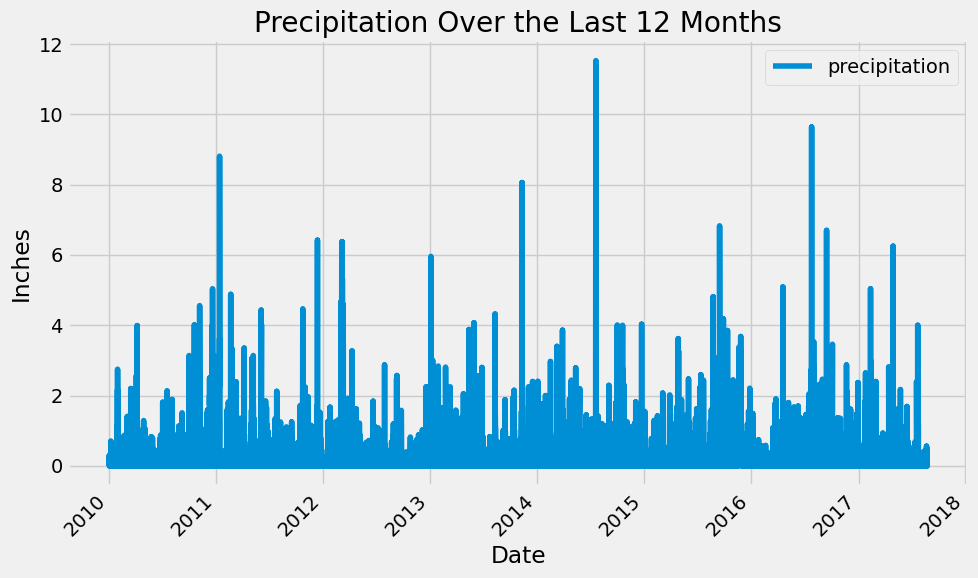

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 



# Calculate the date one year from the last date in data set.

previous_12_months_date = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
print(f"Date 12 months before: {previous_12_months_date}")



# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.prcp.isnot(None)).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.prcp.isnot(None)).all()

# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

#  Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values('date')

# Plot the data using the DataFrame's plot method
precipitation_df.plot(x='date', y='precipitation', figsize=(10,6), legend=True)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Over the Last 12 Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['precipitation'].describe()
print(precipitation_summary)


count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [36]:
# Design a query to calculate the total number of stations in the dataset
session = Session(engine)

total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [38]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

from sqlalchemy import func, desc

most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")





Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [40]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).first()

# Extract the most active station ID
most_active_station_id = most_active_station[0]
print(f"Most active station ID: {most_active_station_id}")

temperature_stats = session.query(
    func.min(Measurement.tobs),  # Lowest temperature
    func.max(Measurement.tobs),  # Highest temperature
    func.avg(Measurement.tobs)   # Average temperature
).filter(Measurement.station == most_active_station_id).all()

# Display the temperature statistics
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"Station {most_active_station_id} - Lowest Temp: {lowest_temp}, Highest Temp: {highest_temp}, Average Temp: {avg_temp:.2f}")

Most active station ID: USC00519281
Station USC00519281 - Lowest Temp: 54.0, Highest Temp: 85.0, Average Temp: 71.66


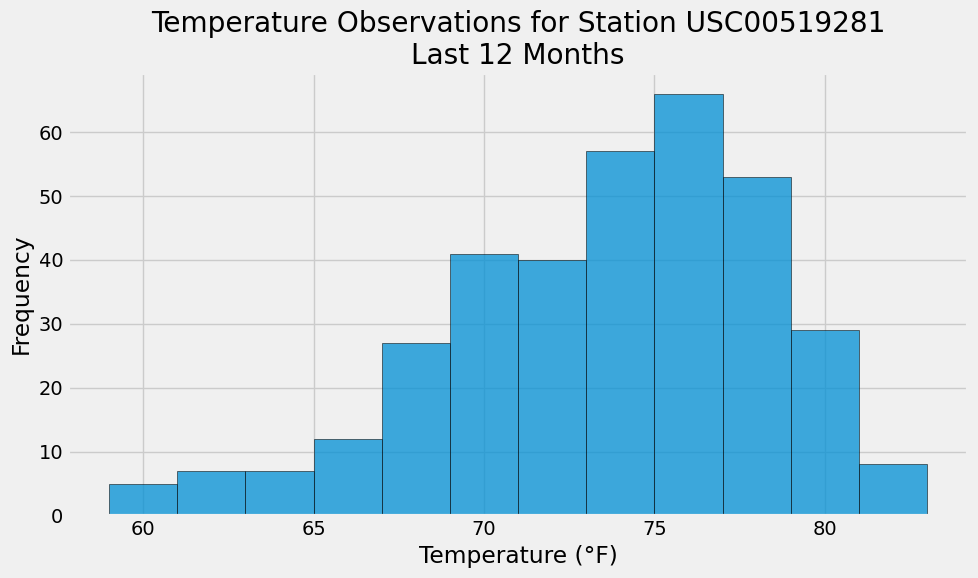

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

previous_12_months_date = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
previous_12_months_date = previous_12_months_date.strftime('%Y-%m-%d')

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= previous_12_months_date).all()

# Convert the query results into a DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['temperature'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['temperature'], bins=12, edgecolor='black', alpha=0.75)
plt.title(f'Temperature Observations for Station {most_active_station_id}\nLast 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# Close Session

In [42]:
# Close Session
session.close()